In [1]:
library(Seurat)

Attaching SeuratObject



In [2]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
eryp.data <- Read10X(
    '../../data/raw/cite-seq/RNA/citeseq180912/outs/filtered_gene_bc_matrices/mm10')

In [4]:
eryp <- CreateSeuratObject(eryp.data, min.cells = 3, min.genes = 200, 
    project = "10X_EryP")

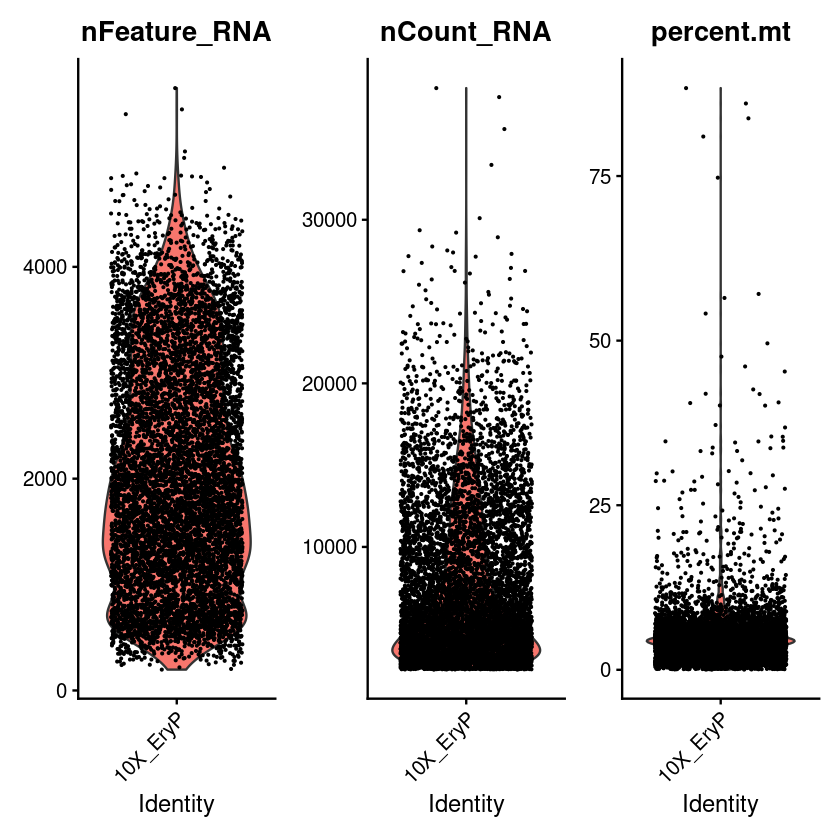

In [5]:
eryp[["percent.mt"]] <- PercentageFeatureSet(eryp, pattern = "^mt-")
VlnPlot(object = eryp, features= c("nFeature_RNA", "nCount_RNA", "percent.mt"))

In [6]:
doublet.scores <- read.table('../../data/intermediate/cite-seq/scrublet_scores.txt',
                             col.names = 'doublet.score', row.names = colnames(eryp.data))

eryp <- AddMetaData(object = eryp, metadata = doublet.scores, col.name = "doublet.score")

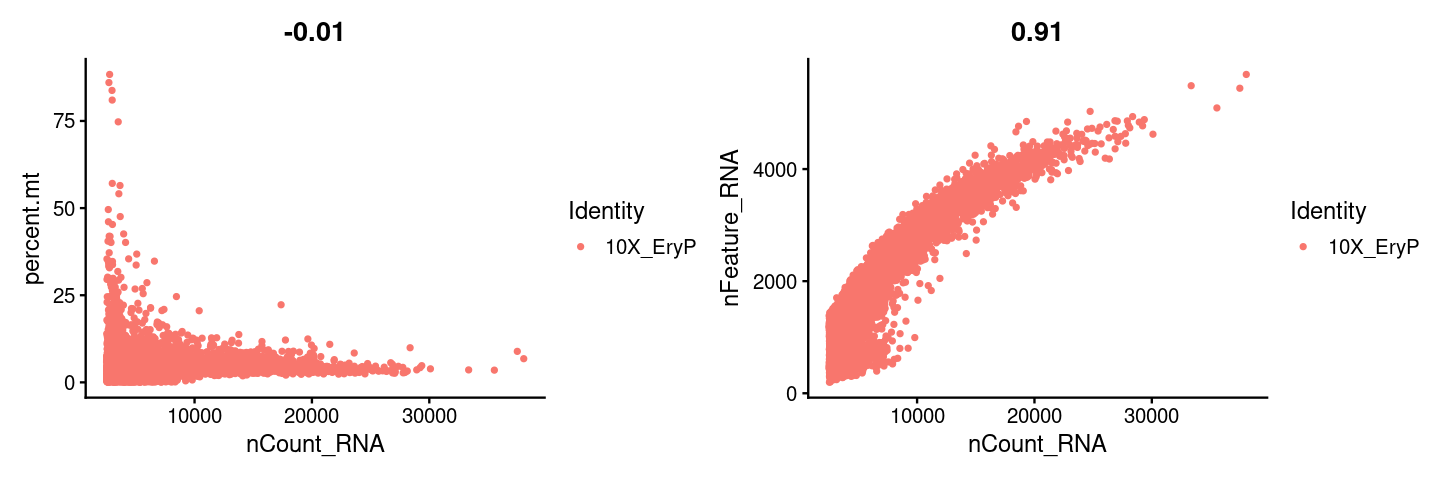

In [7]:
options(repr.plot.width=12, repr.plot.height=4)
plot1 <- FeatureScatter(eryp, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(eryp, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [8]:
scrublet_thresh <- 0.2855555389873682

eryp <- subset(eryp,
               subset = nFeature_RNA > 300 & nFeature_RNA < 5000 & percent.mt < 9 & doublet.score < scrublet_thresh)

In [9]:
eryp <- NormalizeData(object = eryp, normalization.method = "LogNormalize", 
    scale.factor = 10000)


When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


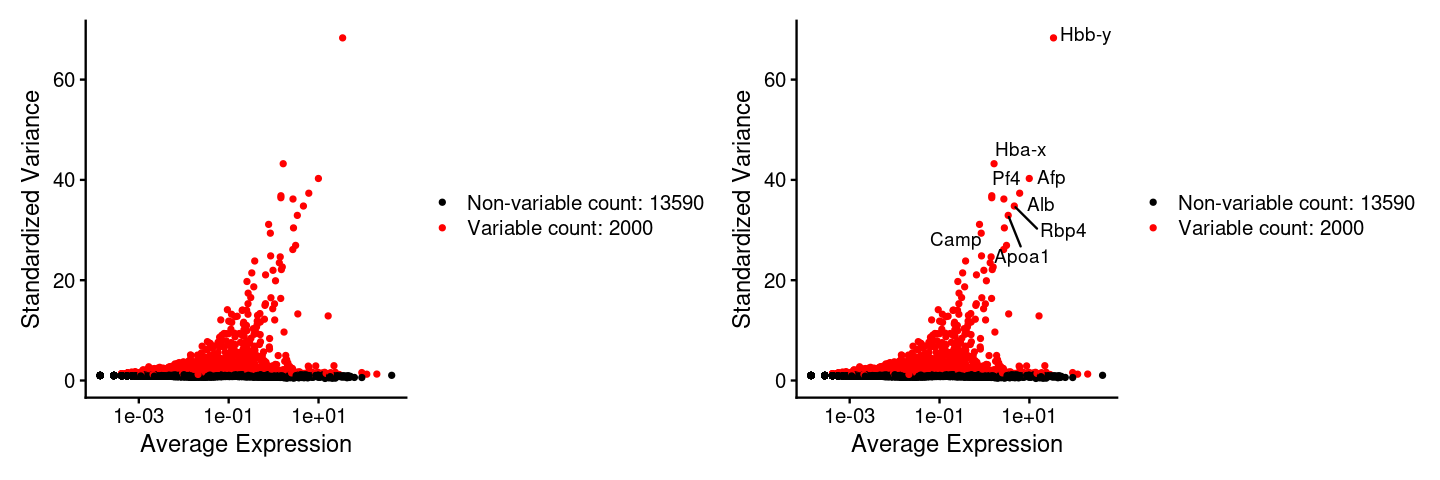

In [10]:
eryp <- FindVariableFeatures(eryp, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(eryp), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(eryp)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

In [11]:
all.genes <- rownames(eryp)
eryp <- ScaleData(eryp, features = all.genes)

Centering and scaling data matrix



In [12]:
eryp <- RunPCA(eryp, features = VariableFeatures(object = eryp))

PC_ 1 
Positive:  Aldob, Cyp2c68, Fgb, Meg3, Aadac, Fgg, Serpina6, Serpina1a, Serpinf2, Serpind1 
	   Itih2, H2-Q10, Kng1, Cpb2, Hpx, Igf2, Gstm1, Krt8, Serpinf1, Serpina1b 
	   Bex2, Apoh, Apob, Cdkn1c, Ahsg, Cfi, Serpinc1, Vtn, Hsd17b2, Fn1 
Negative:  Gypa, Hba-a1, Hbb-bt, Hba-a2, Slc25a37, Alas2, Snca, Hemgn, Rgcc, Mkrn1 
	   Gadd45a, Hbq1b, Nudt4, Tmcc2, Bpgm, Cited4, Fam46c, Hbb-bh1, Bcl2l1, Ube2c 
	   Slc2a1, Adrb2, Tcp11l2, Mrap, Slfn14, Sowaha, Runx1t1, Mns1, Acp5, Hbb-y 
PC_ 2 
Positive:  Hba-a1, Gypa, Hbb-bt, Hba-a2, Alas2, Slc25a37, Snca, Mt2, Hemgn, Mt1 
	   Mkrn1, Ttr, Afp, Fgg, Serpina6, Alb, Apoa2, Serpinc1, Apom, Apoa1 
	   Gadd45a, Serpinf2, Serpina1b, Ambp, Aadac, Serpina1a, Kng1, Fgb, Hpx, Cyp2c68 
Negative:  Arpc1b, Tmsb4x, Sh3bgrl3, Arhgdib, Pkm, Fcer1g, Coro1a, Rac2, Gmfg, Arpc2 
	   Cyba, Actg1, Tyrobp, Cotl1, Spi1, Celf2, Alox5ap, H2afy, Limd2, Srgn 
	   Tagln2, Actr3, Cst3, Lcp1, Laptm5, Ptpn18, Emb, Cmtm7, Tmsb10, Nrros 
PC_ 3 
Positive:  Hba-a2, Hbb-bt, Alas

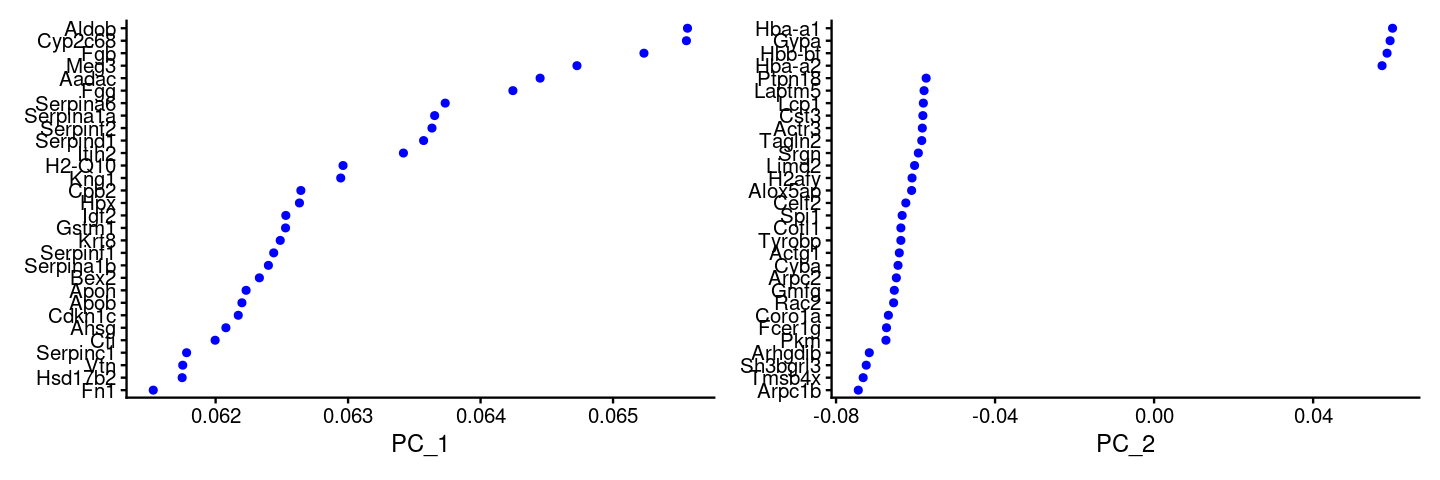

In [13]:
VizDimLoadings(eryp, dims = 1:2, reduction = "pca")

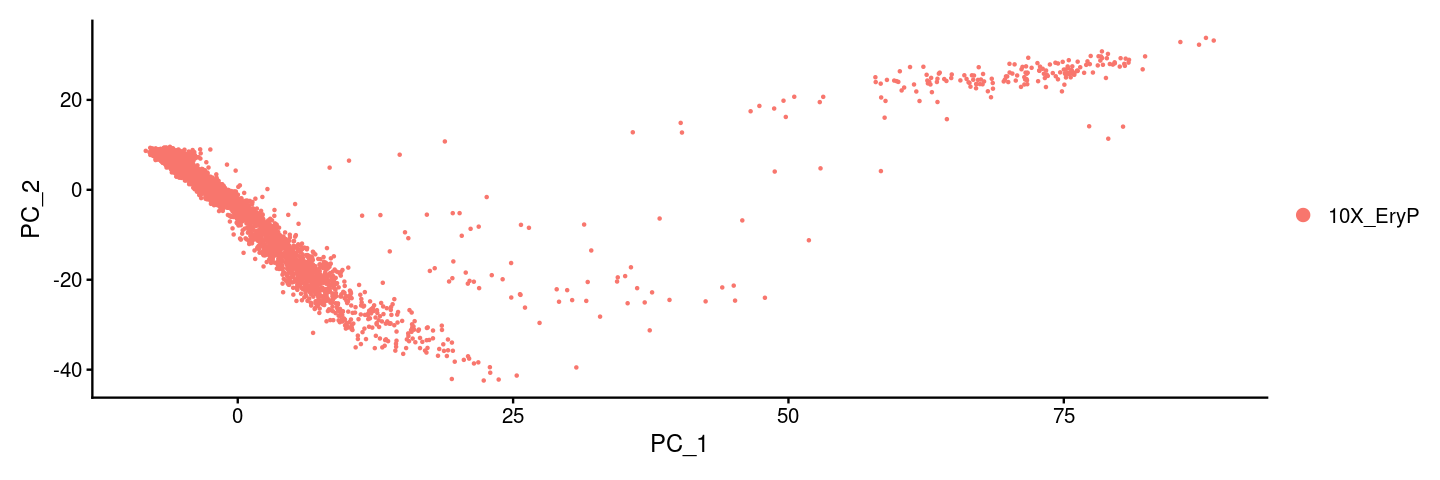

In [14]:
DimPlot(eryp, reduction = "pca")

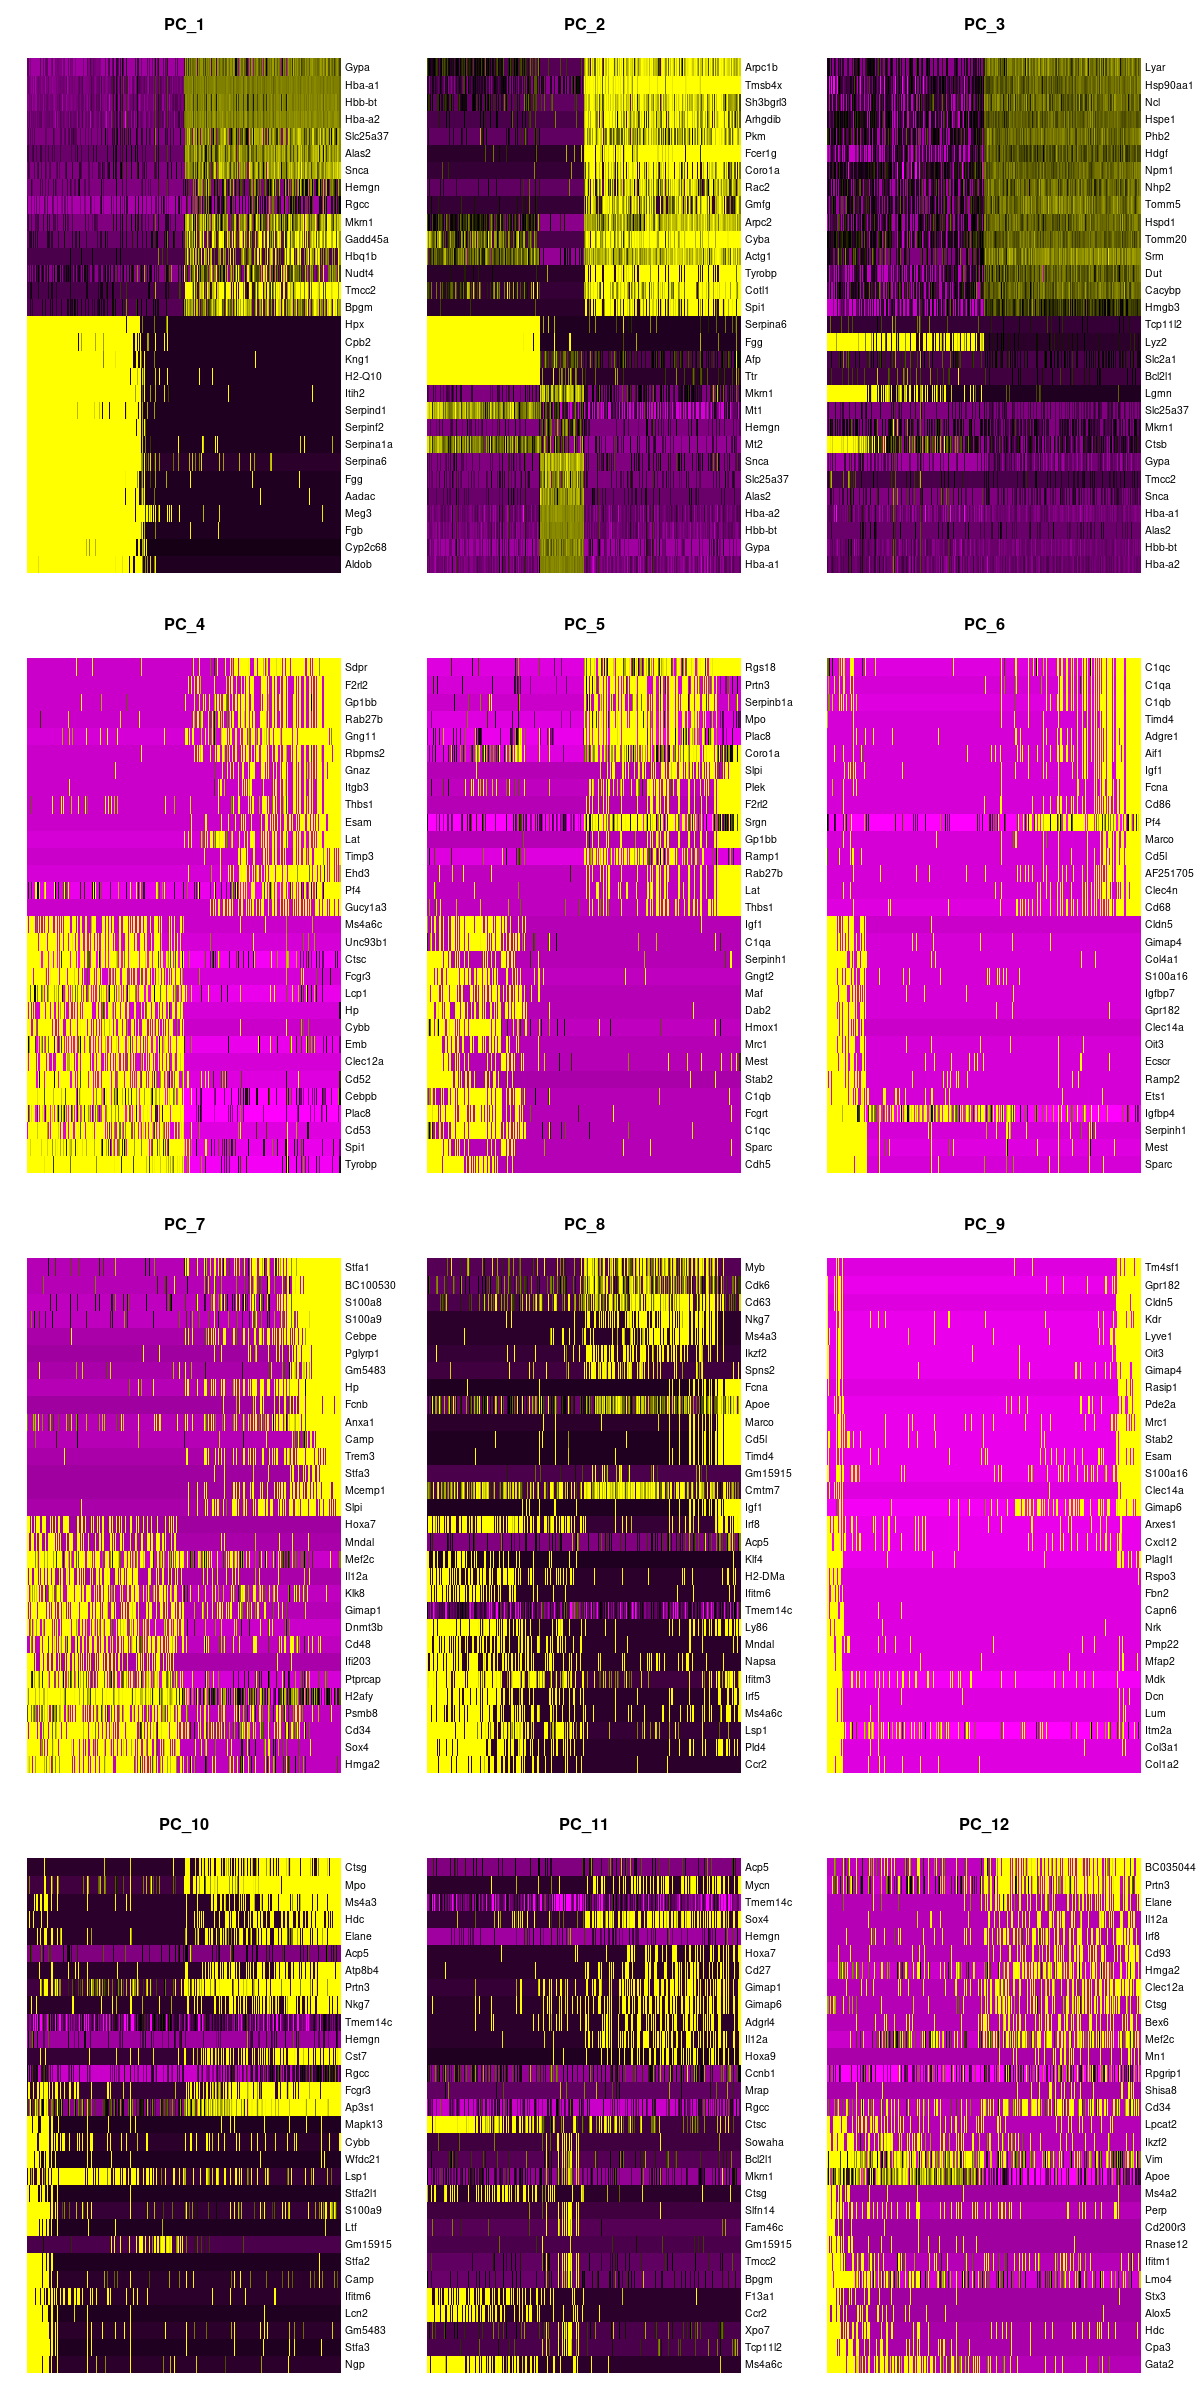

In [15]:
options(repr.plot.width=10, repr.plot.height=20)

DimHeatmap(eryp, dims = 1:12, cells = 500, balanced = TRUE)

In [16]:
eryp <- JackStraw(eryp, num.replicate = 100)
eryp <- ScoreJackStraw(eryp, dims = 1:20)

Warning message:
“Removed 21000 rows containing missing values (geom_point).”


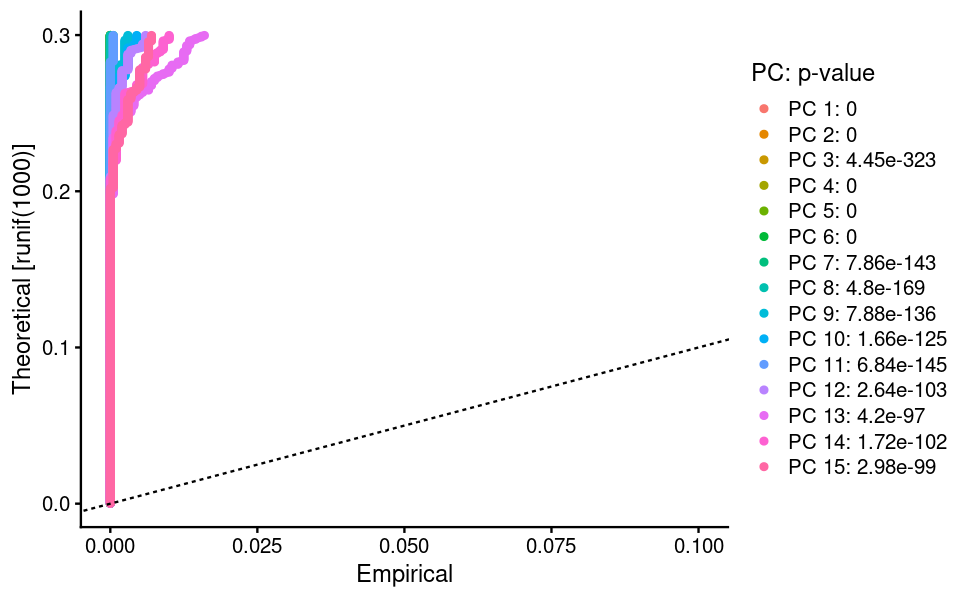

In [17]:
options(repr.plot.width=8, repr.plot.height=5)
JackStrawPlot(eryp, dims = 1:15)

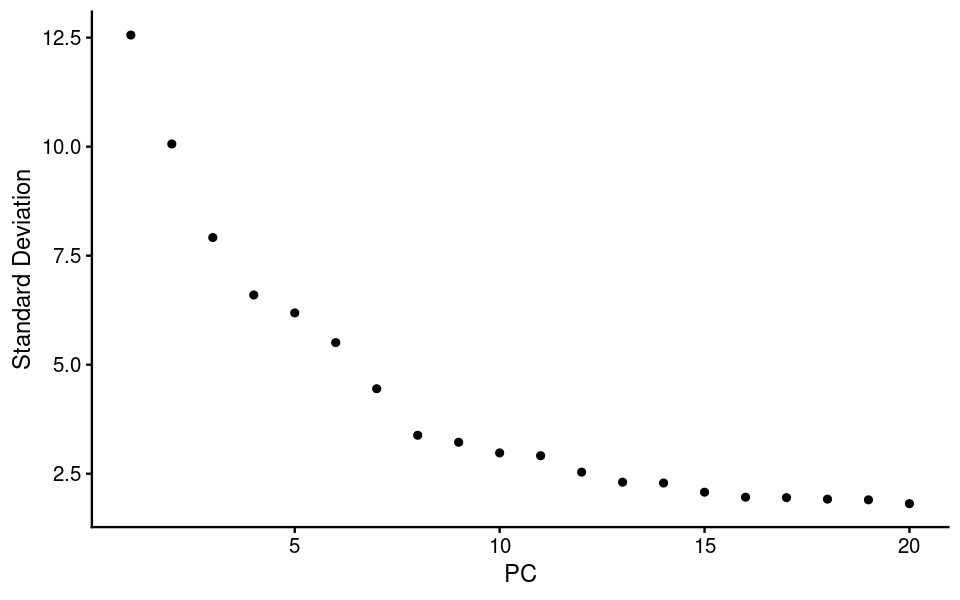

In [18]:
ElbowPlot(eryp)

In [19]:
eryp <- FindNeighbors(eryp, dims = 1:17)
eryp <- FindClusters(eryp, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7212
Number of edges: 282283

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8948
Number of communities: 16
Elapsed time: 0 seconds


In [20]:
eryp <- RunTSNE(eryp, dims.use = 1:10, do.fast = TRUE)


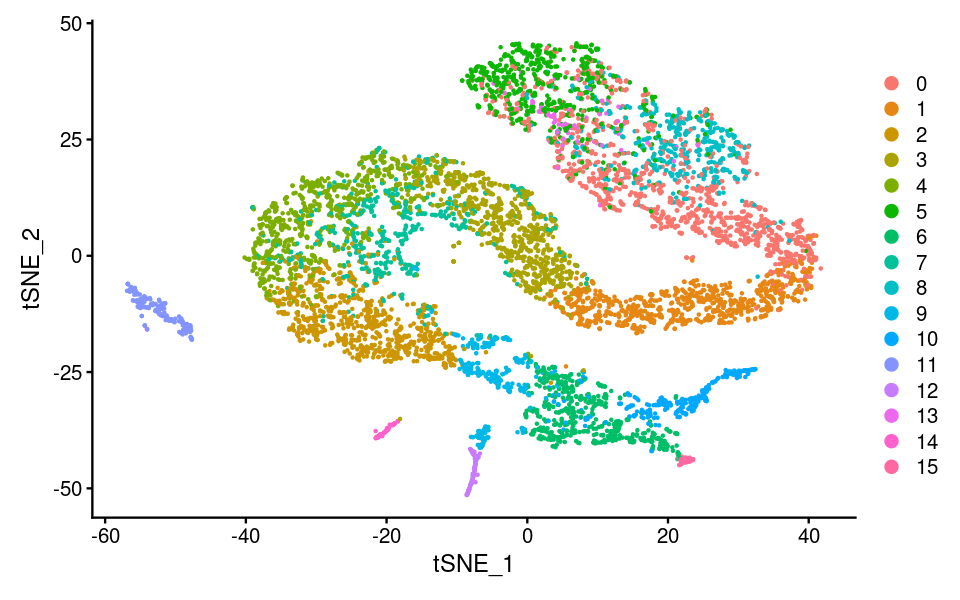

In [21]:
DimPlot(eryp, reduction = "tsne")

In [94]:
eryp.adt <- read.csv("../../data/raw/cite-seq/protein/adt_counts.txt", 
    sep = ",", header = TRUE, row.names = 1)

In [95]:
head(eryp.adt)

,AGGCCACCACGTTGGC,AATCGGTAGCTAACTC,ATGGGAGGTCCTGCTT,TCACAAGGTCGCGGTT,GTGGGTCTCGAGCCCA,GCGCAGTTCCCTTGTG,TACGGATCACATGGGA,AGGGAGTTCGCGATCG,GTCATTTTCTTCGAGA,TCTGGAAGTACGCTGC,⋯,TTTGCGCTCGTTACAG,ACGAGGAGTTGCGTTA,CGCCAAGCAGGCTGAA,CAGAATCTCTGGTGTA,CTCGTACGTGAGGGAG,TCGTACCTCCGCGTTT,TATGCCCTCACCCTCA,GGCGACTTCTCCGGTT,CACAAACTCGGCTTGG,CGAATGTGTCTCGTTC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ADT1,2,4,1,7,10,47,7,26,7,3,⋯,6,247,14,5,5,3,6,3,7,26
ADT10,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ADT2,5,16,6,16,5,9,4,28,73,44,⋯,8,2,152,122,6,18,62,176,6,2
ADT3,5,7,9,6,15,42,19,37,8,4,⋯,9,22,5,3,8,3,11,7,9,3
ADT4,1,3,3,6,2,5,4,16,3,2,⋯,1,2,5,2,3,1,0,0,3,1
ADT5,7,13,20,15,4,13,9,67,15,9,⋯,11,5,11,15,10,14,12,8,14,6


In [96]:
dim(eryp.adt)

[1]   13 7863

In [97]:
# Add pseudocount
eryp.adt <- log10(eryp.adt + 1)

In [98]:
                        #ADT1    ADT10    ADT2
rownames(eryp.adt) <- c('CD11b', 'IgG', 'Ter119',
                        #ADT3    ADT4    ADT5
                        'CD41', 'Gr1', 'B220',
                        #ADT6    ADT7    ADT8
                        'cKit', 'CD3e', 'CD44',
                        #ADT9
                        'CD71', 'bad_struct', 'no_match', 'total_reads')

In [99]:
eryp.adt <- rbind(eryp.adt, colSums(eryp.adt[c('Gr1', 'CD11b', 'CD3e', 'CD41', 'B220'), ]))

In [100]:
rownames(eryp.adt)[14] <- 'Lin'

In [101]:
rows_to_keep = !(rownames(eryp.adt) %in% c('bad_struct', 'no_match', 'total_reads'))

In [102]:
eryp.adt <- eryp.adt[rows_to_keep, ]

In [103]:
#rownames(eryp.adt) <- paste0("CITE-", rownames(eryp.adt))

In [104]:
head(eryp.adt)

,AGGCCACCACGTTGGC,AATCGGTAGCTAACTC,ATGGGAGGTCCTGCTT,TCACAAGGTCGCGGTT,GTGGGTCTCGAGCCCA,GCGCAGTTCCCTTGTG,TACGGATCACATGGGA,AGGGAGTTCGCGATCG,GTCATTTTCTTCGAGA,TCTGGAAGTACGCTGC,⋯,TTTGCGCTCGTTACAG,ACGAGGAGTTGCGTTA,CGCCAAGCAGGCTGAA,CAGAATCTCTGGTGTA,CTCGTACGTGAGGGAG,TCGTACCTCCGCGTTT,TATGCCCTCACCCTCA,GGCGACTTCTCCGGTT,CACAAACTCGGCTTGG,CGAATGTGTCTCGTTC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD11b,0.4771213,0.698970,0.301030,0.903090,1.0413927,1.6812412,0.90309,1.431364,0.9030900,0.6020600,⋯,0.8450980,2.3944517,1.1760913,0.7781513,0.7781513,0.602060,0.845098,0.6020600,0.903090,1.4313638
IgG,0.0000000,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.00000,0.000000,0.0000000,0.0000000,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.000000,0.0000000,0.000000,0.0000000
Ter119,0.7781513,1.230449,0.845098,1.230449,0.7781513,1.0000000,0.69897,1.462398,1.8692317,1.6532125,⋯,0.9542425,0.4771213,2.1846914,2.0899051,0.8450980,1.278754,1.799341,2.2479733,0.845098,0.4771213
CD41,0.7781513,0.903090,1.000000,0.845098,1.2041200,1.6334685,1.30103,1.579784,0.9542425,0.6989700,⋯,1.0000000,1.3617278,0.7781513,0.6020600,0.9542425,0.602060,1.079181,0.9030900,1.000000,0.6020600
Gr1,0.3010300,0.602060,0.602060,0.845098,0.4771213,0.7781513,0.69897,1.230449,0.6020600,0.4771213,⋯,0.3010300,0.4771213,0.7781513,0.4771213,0.6020600,0.301030,0.000000,0.0000000,0.602060,0.3010300
B220,0.9030900,1.146128,1.322219,1.204120,0.6989700,1.1461280,1.00000,1.832509,1.2041200,1.0000000,⋯,1.0791812,0.7781513,1.0791812,1.2041200,1.0413927,1.176091,1.113943,0.9542425,1.176091,0.8450980


In [105]:
library(stringr)

In [106]:
valid_cell_barcodes = str_replace(colnames(eryp[["RNA"]]), '-1', '')

In [107]:
eryp.adt <- eryp.adt[,(colnames(eryp.adt) %in% valid_cell_barcodes)]

In [108]:
colnames(eryp.adt) <- paste(colnames(eryp.adt), '-1', sep='')

In [109]:
adt_assay <- CreateAssayObject(counts = eryp.adt)

In [110]:
eryp[["CITE"]] <- adt_assay

In [111]:
Assays(eryp)

[1] "RNA"  "CITE"

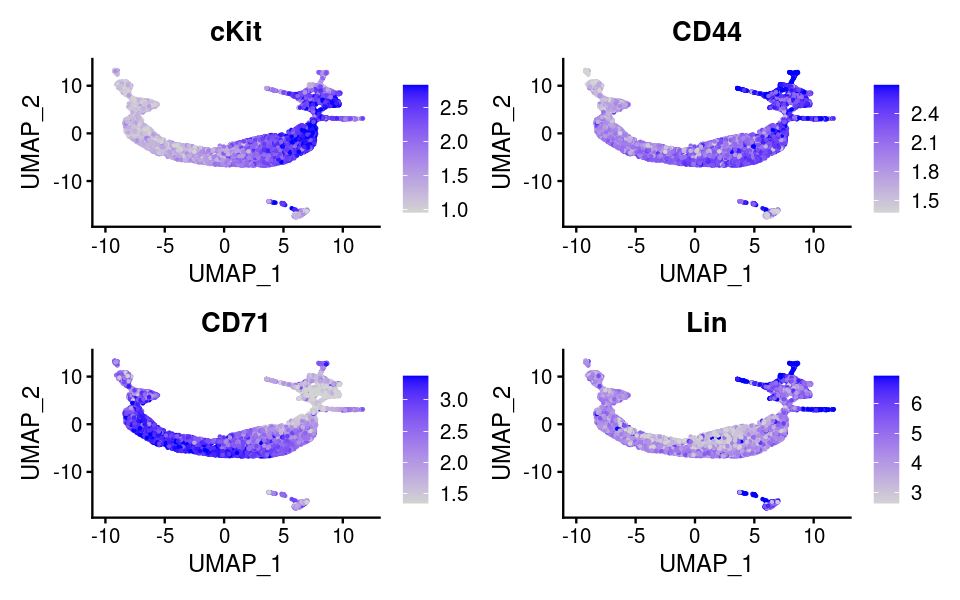

In [112]:
DefaultAssay(eryp) <- "CITE"
FeaturePlot(eryp, features = c("cKit", "CD44", "CD71", "Lin"),
            cols = c("lightgrey", "blue"), min.cutoff = "q05", max.cutoff = "q95")

In [63]:
DefaultAssay(eryp) <- "RNA"
eryp <- RunUMAP(eryp, dims = 1:17)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
18:46:26 UMAP embedding parameters a = 0.9922 b = 1.112

18:46:26 Read 7212 rows and found 17 numeric columns

18:46:26 Using Annoy for neighbor search, n_neighbors = 30

18:46:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:46:27 Writing NN index file to temp file /tmp/RtmpYnVm0g/file24144379763b

18:46:27 Searching Annoy index using 1 thread, search_k = 3000

18:46:30 Annoy recall = 100%

18:46:30 Commencing smooth kNN distance calibration using 1 thread

18:46:31 Initializing fro

In [64]:
clusters <- read.csv(
    '../../data/intermediate/cite-seq/clusters.csv',
    col.names=c('barcode', 'cluster'))

In [65]:
clusters[["barcode"]] <- paste(clusters[["barcode"]], '-1', sep='')

In [66]:
clusters2 <- clusters[,2, drop=F]

In [67]:
rownames(clusters2) <- clusters[["barcode"]]

In [68]:
eryp <- AddMetaData(eryp, clusters2, col.name="cluster")

In [69]:
eryp <- SetIdent(eryp, value="cluster")

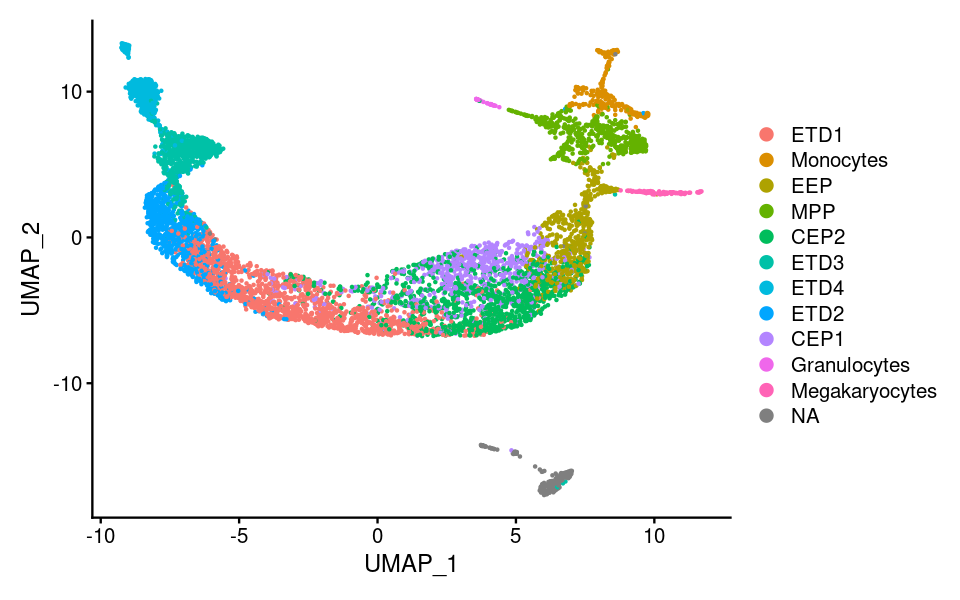

In [92]:
DimPlot(eryp, reduction = "umap")

In [113]:
saveRDS(eryp, '../../data/intermediate/cite-seq/seurat-initial-qc.rds')